In [1]:
%cd "../fiberphotopy"

C:\Users\mceau\Documents\fiberphotopy\fiberphotopy


In [2]:
import behavioral_data
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [3]:
levers = behavioral_data.MultiBehavior('../../DATA/lever')

Importing ../../DATA/lever\J37sac\bsa24032022s1c01_01.dat...
Importing of ../../DATA/lever\J37sac\bsa24032022s1c01_01.dat finished in 0.047969818115234375 seconds
Importing ../../DATA/lever\J37sac\bsa24032022s1c02_01.dat...
Importing of ../../DATA/lever\J37sac\bsa24032022s1c02_01.dat finished in 0.028982877731323242 seconds
Importing ../../DATA/lever\J37sac\bsa24032022s1c03_01.dat...
Importing of ../../DATA/lever\J37sac\bsa24032022s1c03_01.dat finished in 0.03697824478149414 seconds
Importing ../../DATA/lever\J37sac\bsa24032022s1c04_01.dat...
Importing of ../../DATA/lever\J37sac\bsa24032022s1c04_01.dat finished in 0.02798318862915039 seconds
Importing ../../DATA/lever\J37sac\bsa24032022s1c05_01.dat...
Importing of ../../DATA/lever\J37sac\bsa24032022s1c05_01.dat finished in 0.022986412048339844 seconds
Importing ../../DATA/lever\J37sac\bsa24032022s1c06_01.dat...
Importing of ../../DATA/lever\J37sac\bsa24032022s1c06_01.dat finished in 0.03897881507873535 seconds
Importing ../../DATA/leve

In [4]:
levers.__dict__.keys()

dict_keys(['sessions', 'paths', 'names', 'number', 'hello', 'configfile', 'config', 'rat_ID', 'file_unit', 'user_unit', 'experiment_duration', 'fixed_ratio', 'close_interval', 'elements', 'df', 'custom', 'filepath', 'start', 'end', 'time_ratio', 'hled_on', 'hled_off', 'led1_on', 'led1_off', 'led2_on', 'led2_off', 'np1', 'np2', 'inj1', 'ttl1_on', 'ttl1_off', 'rec_start', 'HLED_ON', 'HLED_OFF', 'LED1_ON', 'LED1_OFF', 'LED2_ON', 'LED2_OFF', 'TTL1_ON', 'TTL1_OFF', 'DARK', 'TO_DARK', 'TIMEOUT', 'NOTO_DARK', 'switch_d_nd', 'switch_to_nd', 'switch_nd_d', 'switch_dto_nd', 'np1_1', 'np1_2', 'np1_3', 'np1_4', 'np1_5', 'ND_1', 'x', 'y', 'xytime', 'l1_0', 'l1_1', 'lk1_start', 'lk1_end', 'LK1', 'lk1_intnb', 'D_1'])

In [5]:
c1 = levers.sessions['../../DATA/lever\\J41sac\\bsa30032022s1c01_01.dat']

,count,TIME,F,ID,_P,_V,_L,_R,_T,_W,_X,_Y,_Z
LK1,911,993338.536,5.0,1.0,,0.499,,,,2924.975,,2924.975,
L1,890,1040733.751,2.0,1.0,0.961,0.336,0.372,,146.787,,0.108,146.679,
ON,628,1071798.495,10.0,1.0,1.0,1.0,,,3.363,,,,
INJ1,276,1007235.268,6.0,1.0,,,1.0,,138.5,,,,
Z1,122,1337120.205,9.0,1.0,,1.418,30.918,35.156,91.951,41.992,1.418,1.0,1.0
NP1,46,1616044.87,3.0,1.0,1.0,0.5,0.5,,12.0,,,12.0,
I,2,2400013.0,11.0,4.0,,3.0,,,,,,,
HLED,1,,1.0,1.0,1.0,1.0,1.0,,1.0,,,,


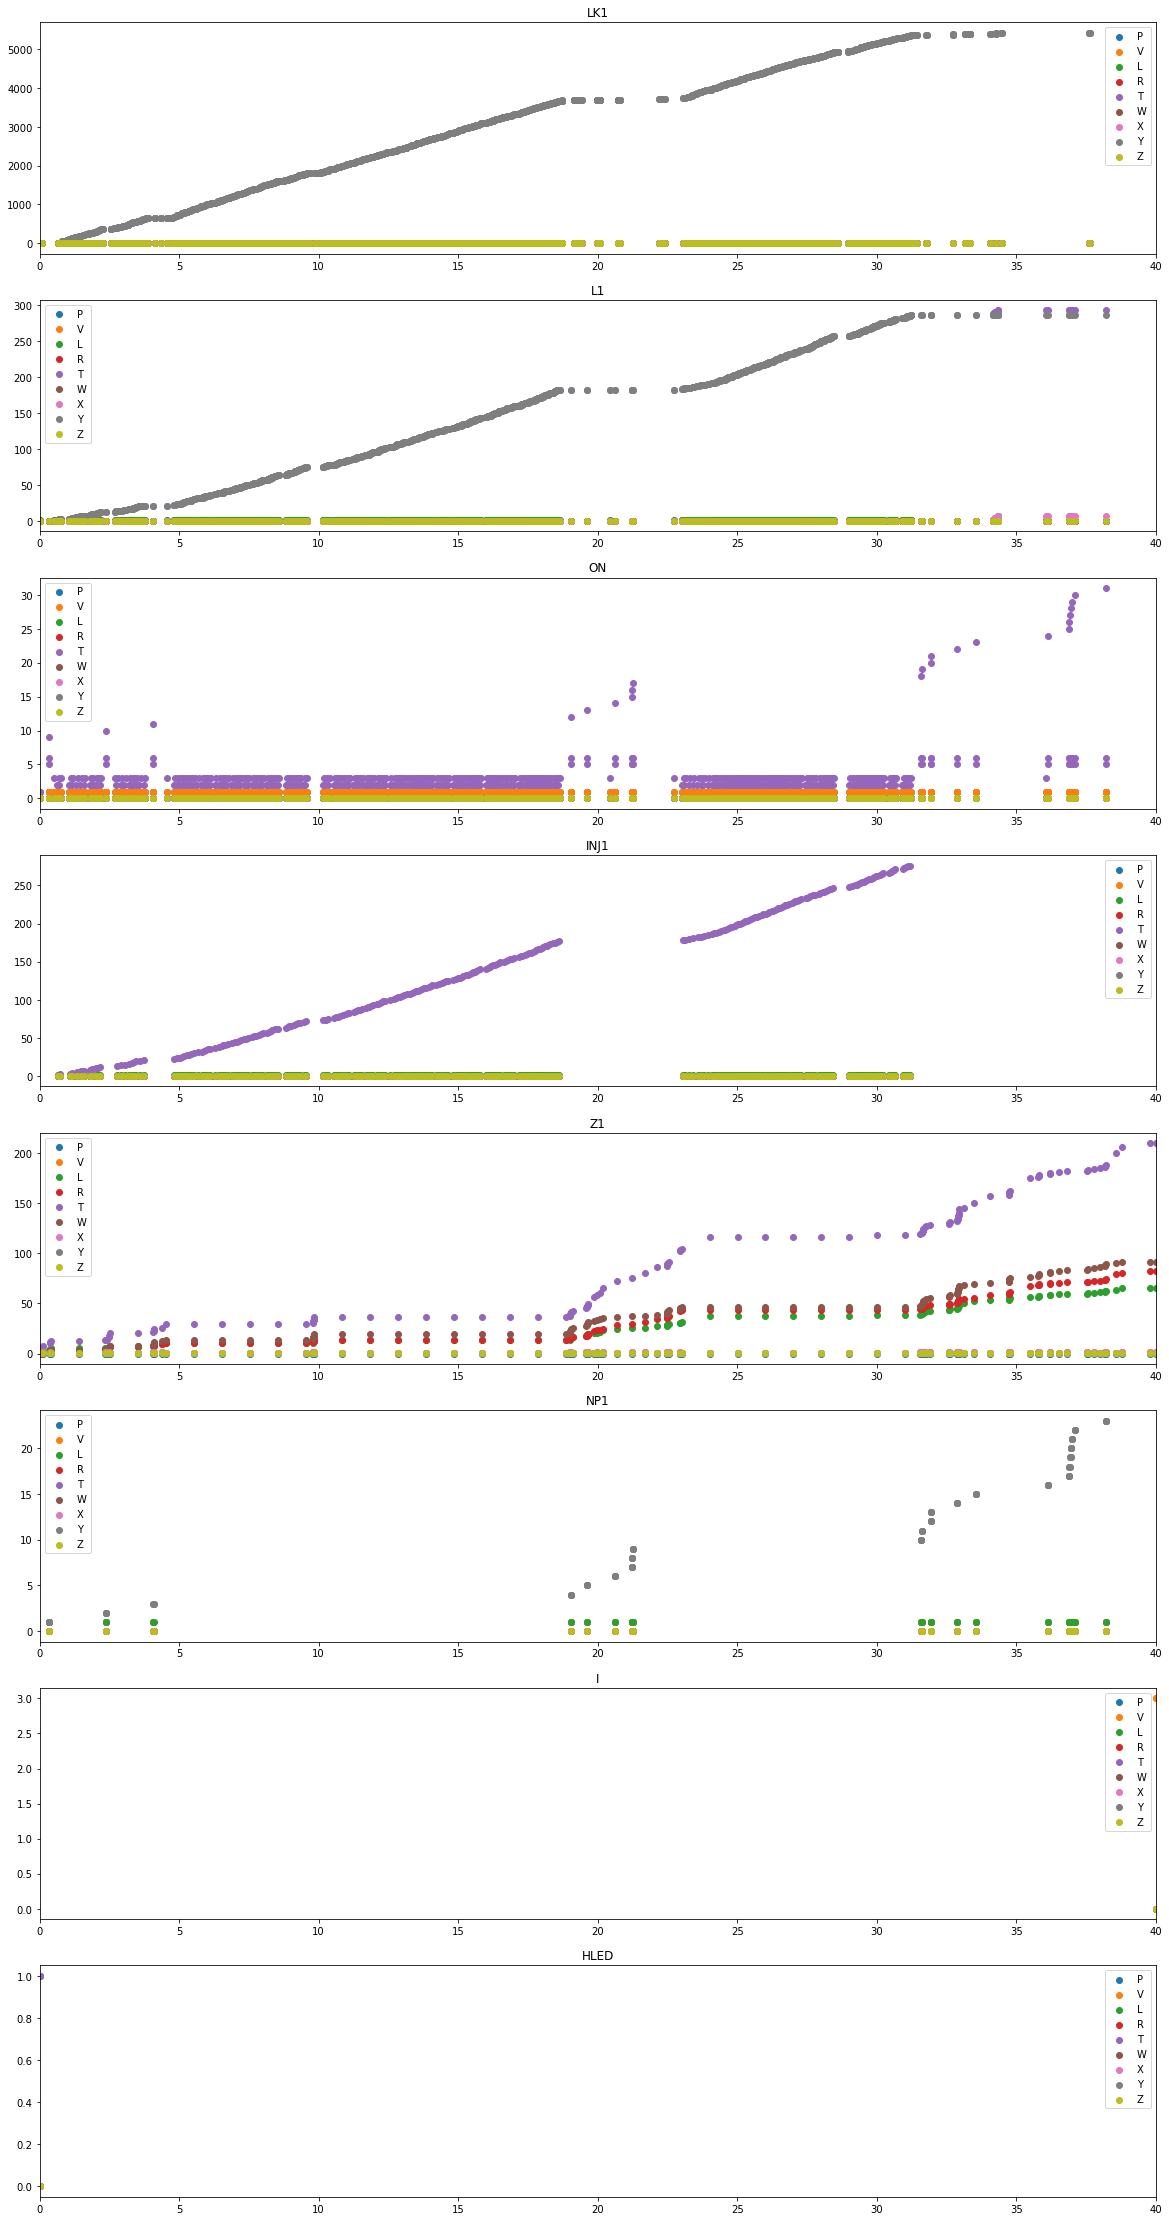

In [6]:
c1.what_data()

In [22]:
c1.np1.size

23

,count,TIME,F,ID,_P,_V,_L,_R,_T,_W,_X,_Y,_Z
LK1,911,993338.536,5.0,1.0,,0.499,,,,2924.975,,2924.975,
L1,890,1040733.751,2.0,1.0,0.961,0.336,0.372,,146.787,,0.108,146.679,
ON,628,1071798.495,10.0,1.0,1.0,1.0,,,3.363,,,,
INJ1,276,1007235.268,6.0,1.0,,,1.0,,138.5,,,,
Z1,122,1337120.205,9.0,1.0,,1.418,30.918,35.156,91.951,41.992,1.418,1.0,1.0
NP1,46,1616044.87,3.0,1.0,1.0,0.5,0.5,,12.0,,,12.0,
I,2,2400013.0,11.0,4.0,,3.0,,,,,,,
HLED,1,,1.0,1.0,1.0,1.0,1.0,,1.0,,,,


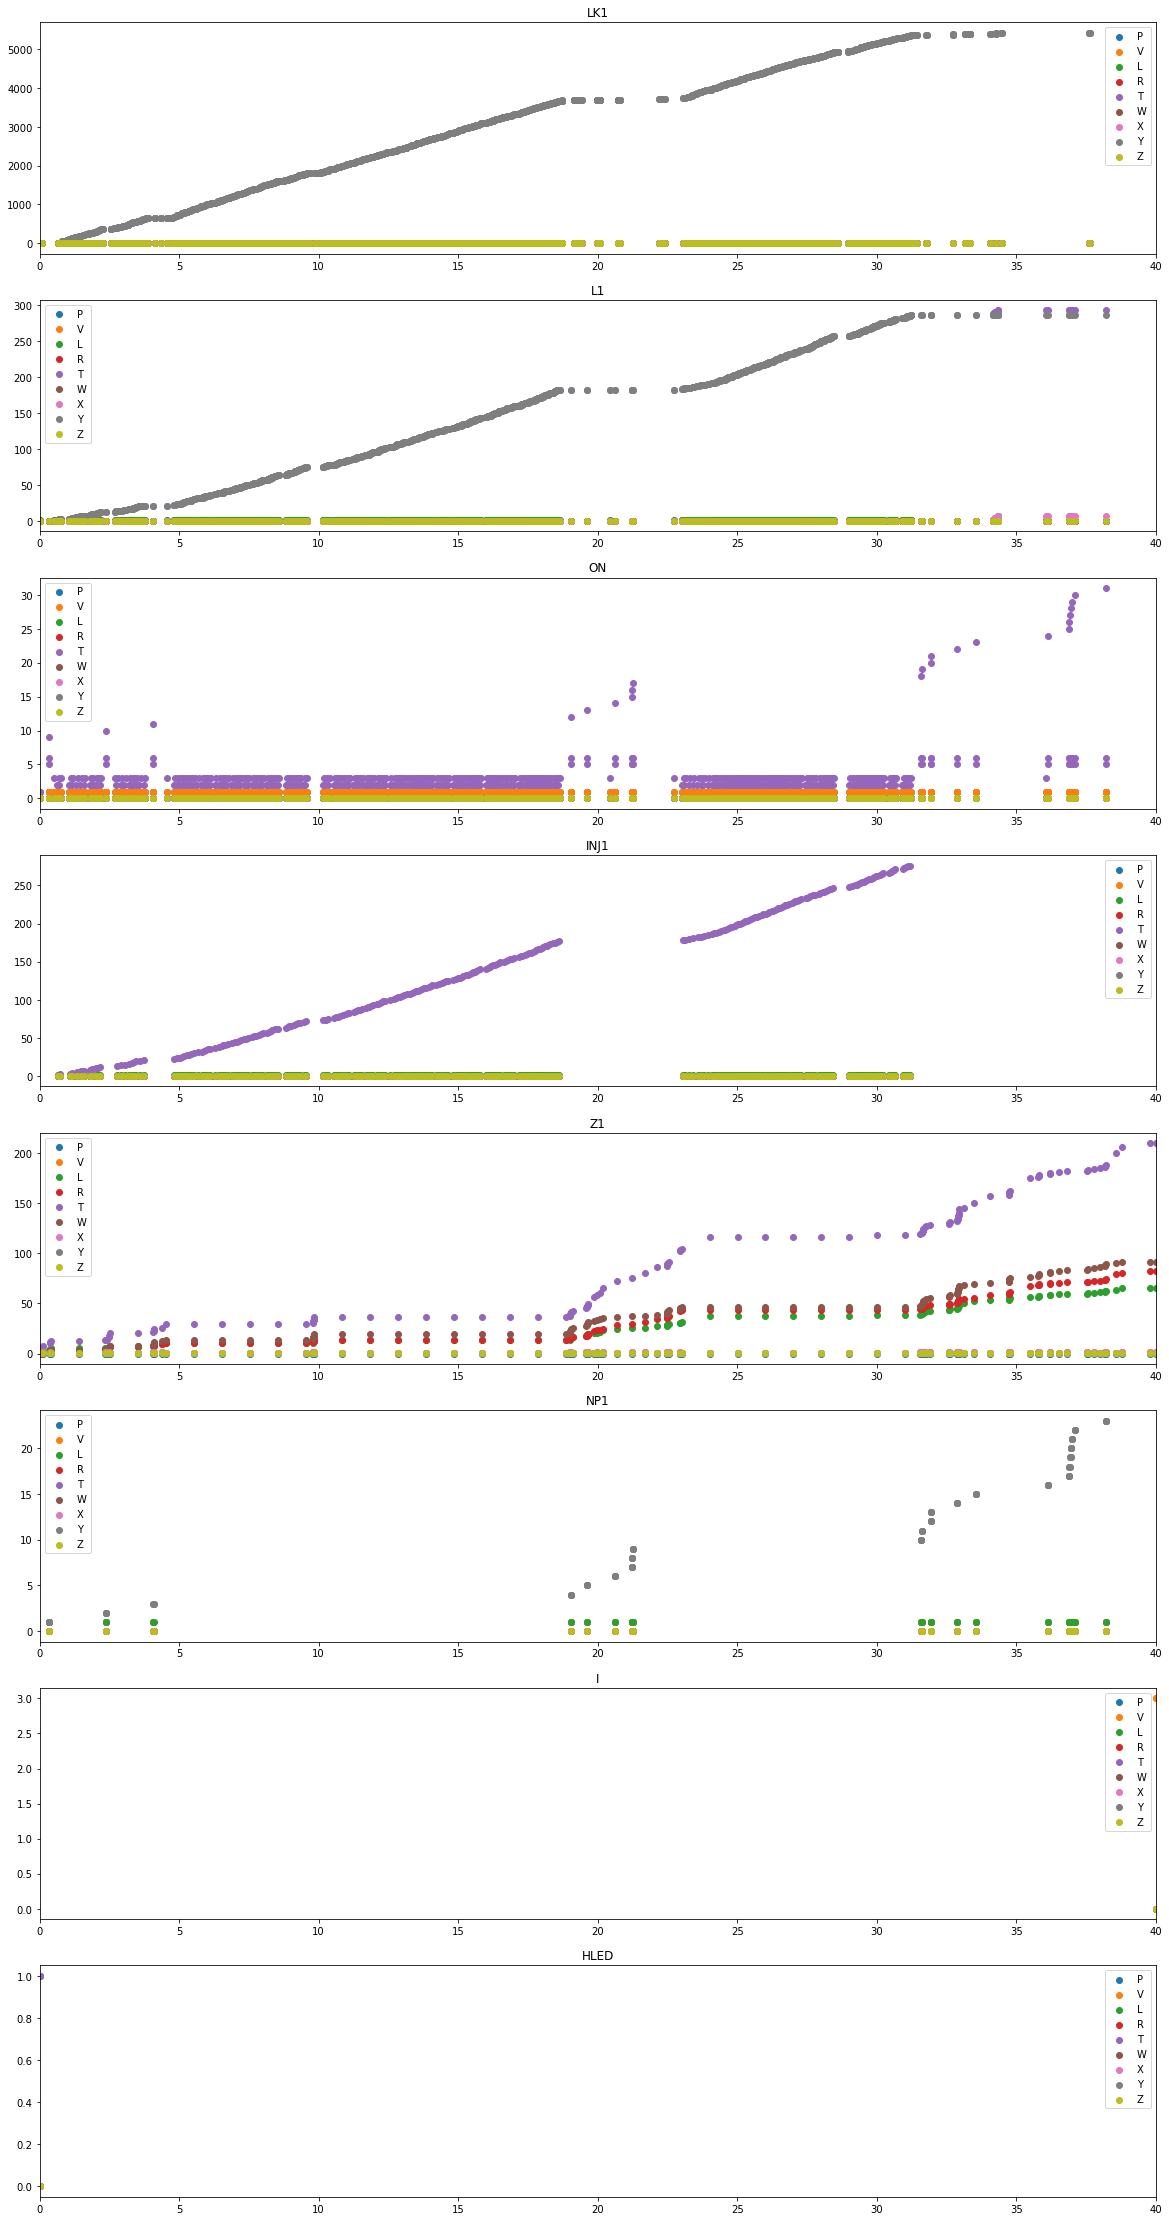

In [7]:
c1.what_data()

In [8]:
c1.get('LK1')

,TIME,F,ID,_P,_V,_L,_R,_T,_W,_X,_Y,_Z
3,343,5,1,0,0,0,0,0,1,0,1,0
7,4150,5,1,0,1,0,0,0,2,0,2,0
8,4555,5,1,0,0,0,0,0,3,0,3,0
25,39172,5,1,0,1,0,0,0,4,0,4,0
28,41325,5,1,0,0,0,0,0,16,0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2792,2057575,5,1,0,0,0,0,0,5406,0,5406,0
2797,2068059,5,1,0,1,0,0,0,5407,0,5407,0
2798,2069494,5,1,0,0,0,0,0,5415,0,5415,0
2858,2257288,5,1,0,1,0,0,0,5416,0,5416,0


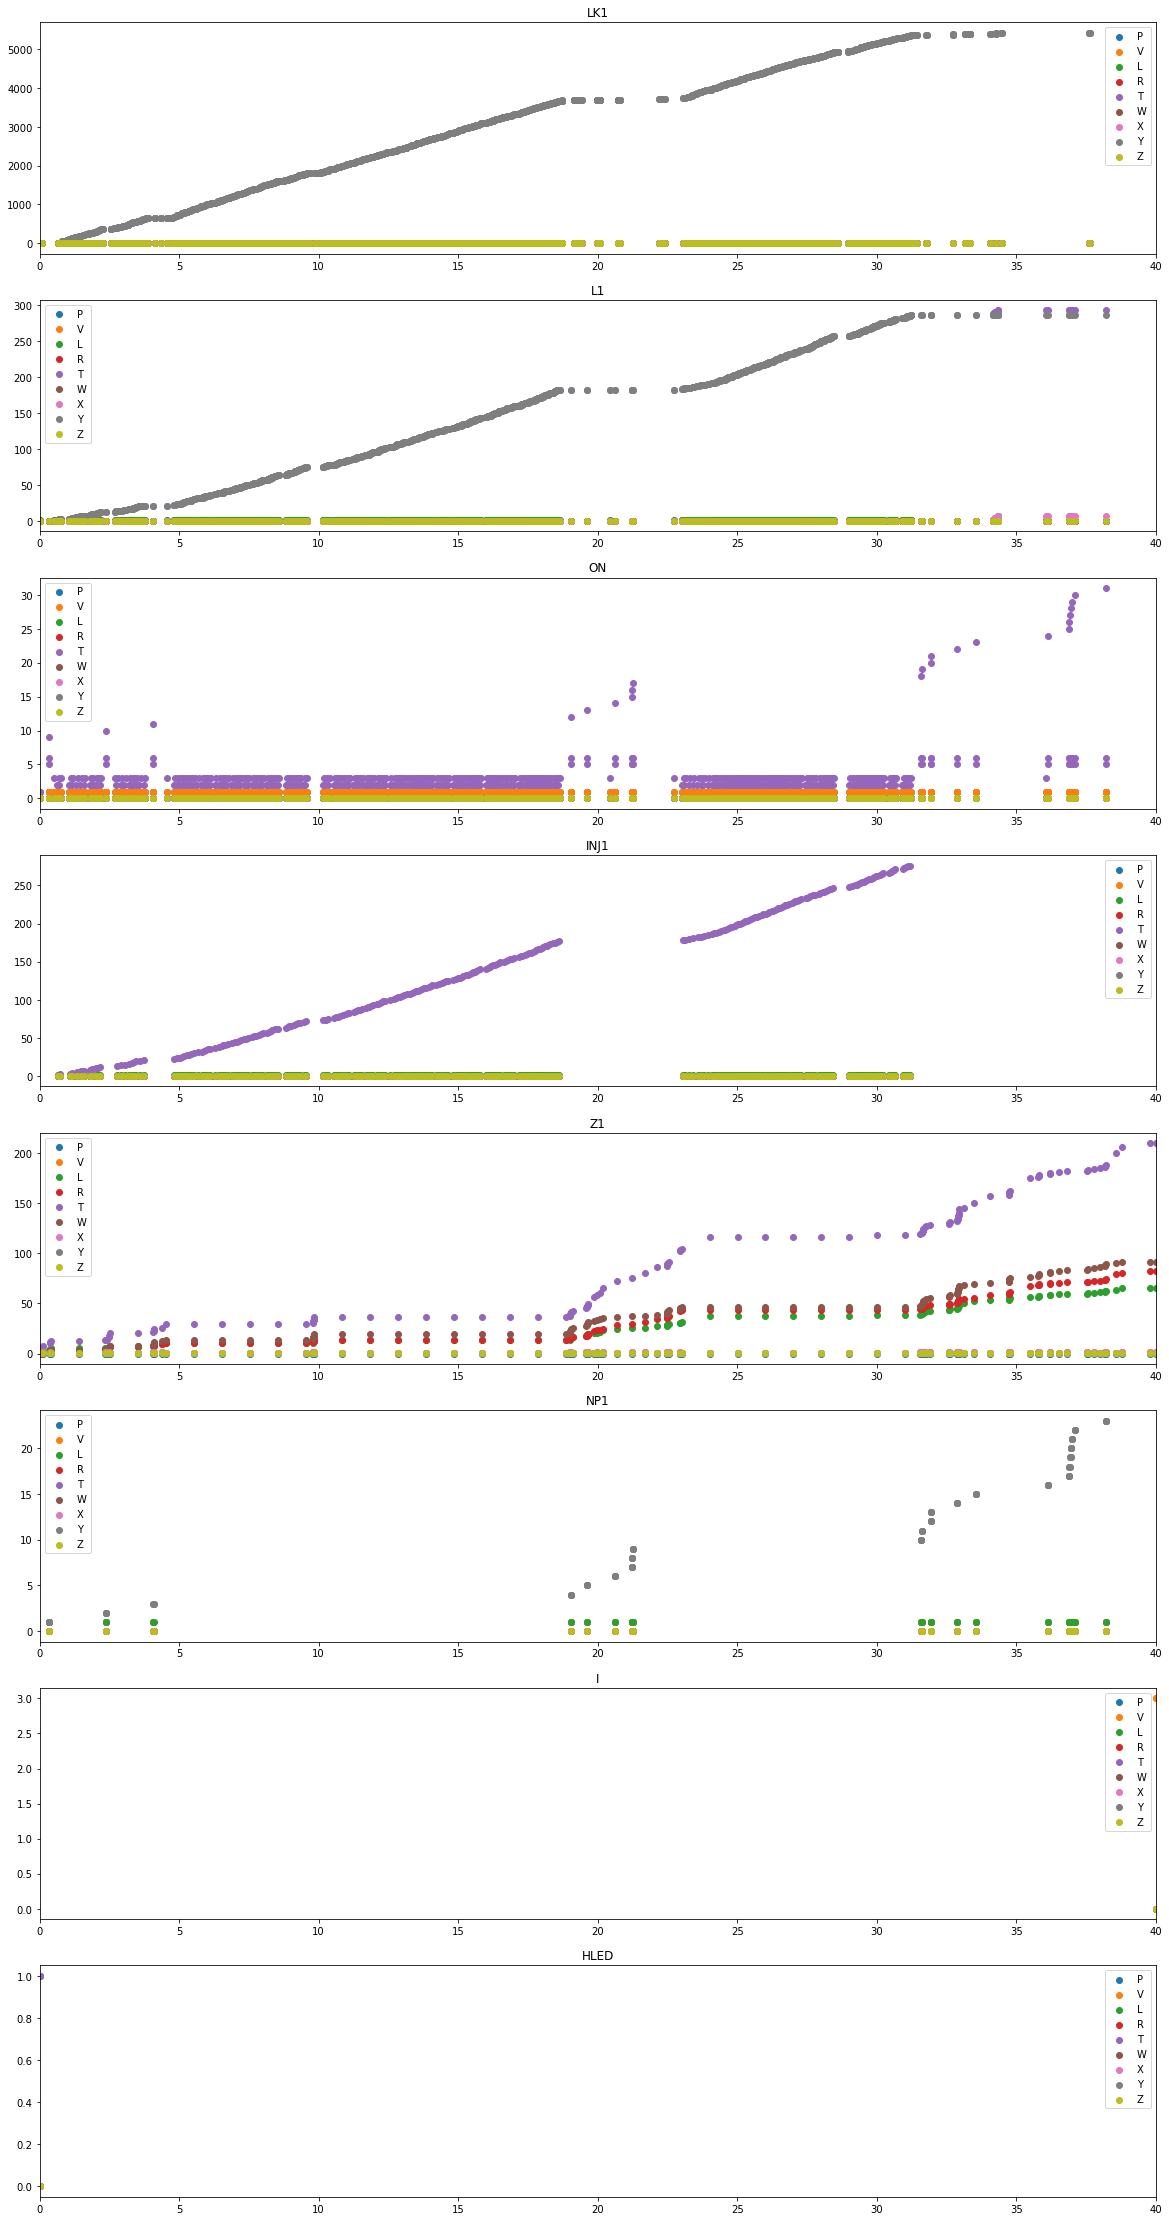

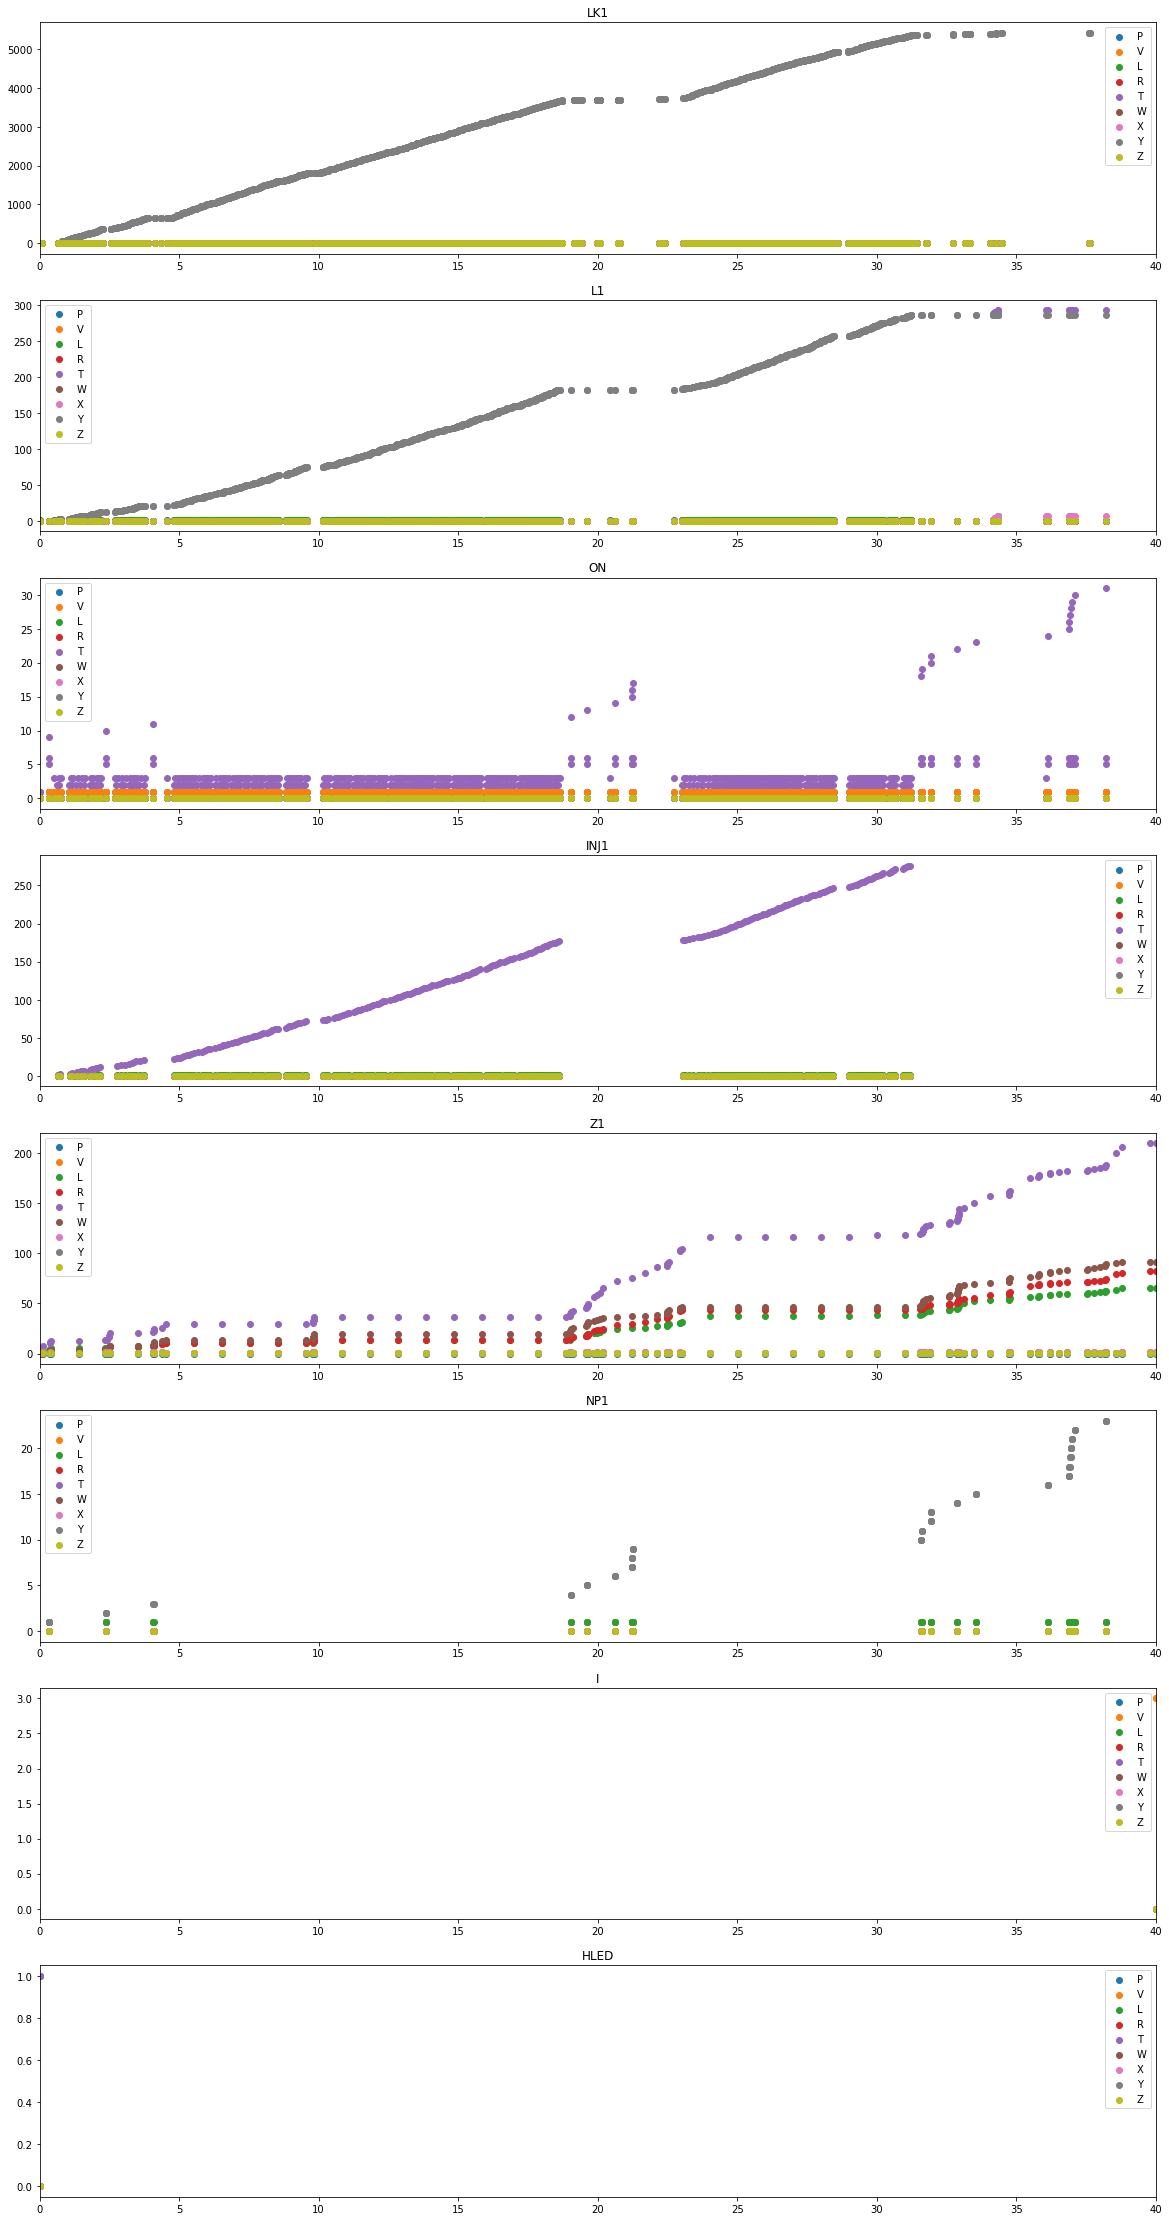

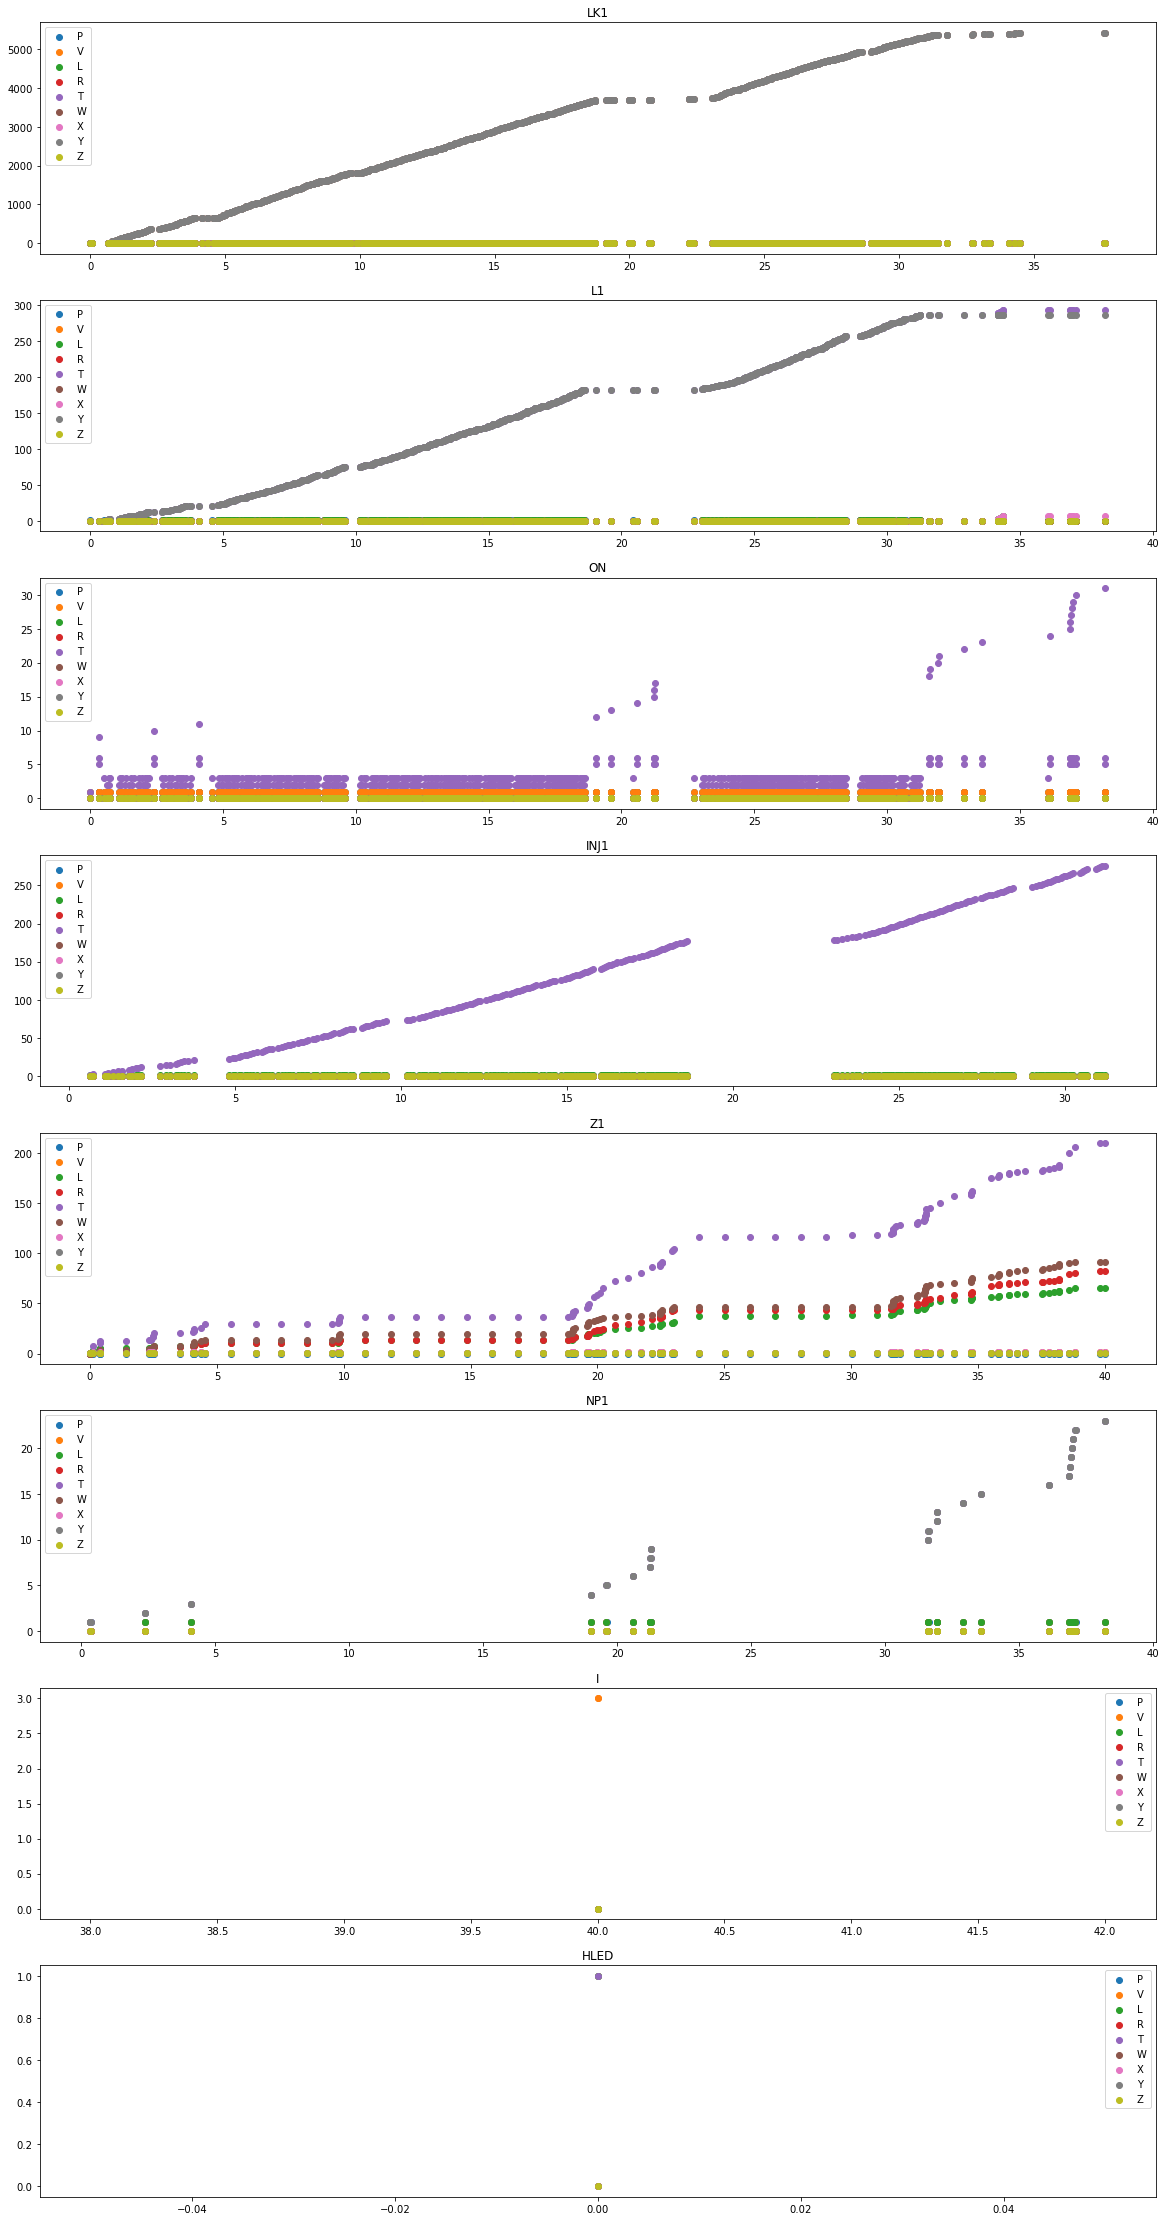

In [9]:
names = c1.what_data().index.values
columns = c1.what_data().columns.values[4:]
fig,axes = plt.subplots(len(names),figsize=(20,40))
for n,ax in enumerate(axes):
    name = names[n]
    df = c1.get(name)
    for c in columns:
        ax.scatter(df['TIME']/60_000,df[c],label=c.split('_')[1])
    ax.legend()
    ax.title.set_text(name)

In [29]:
c1.get('LK1')

,TIME,F,ID,_P,_V,_L,_R,_T,_W,_X,_Y,_Z
3,343,5,1,0,0,0,0,0,1,0,1,0
7,4150,5,1,0,1,0,0,0,2,0,2,0
8,4555,5,1,0,0,0,0,0,3,0,3,0
25,39172,5,1,0,1,0,0,0,4,0,4,0
28,41325,5,1,0,0,0,0,0,16,0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2792,2057575,5,1,0,0,0,0,0,5406,0,5406,0
2797,2068059,5,1,0,1,0,0,0,5407,0,5407,0
2798,2069494,5,1,0,0,0,0,0,5415,0,5415,0
2858,2257288,5,1,0,1,0,0,0,5416,0,5416,0


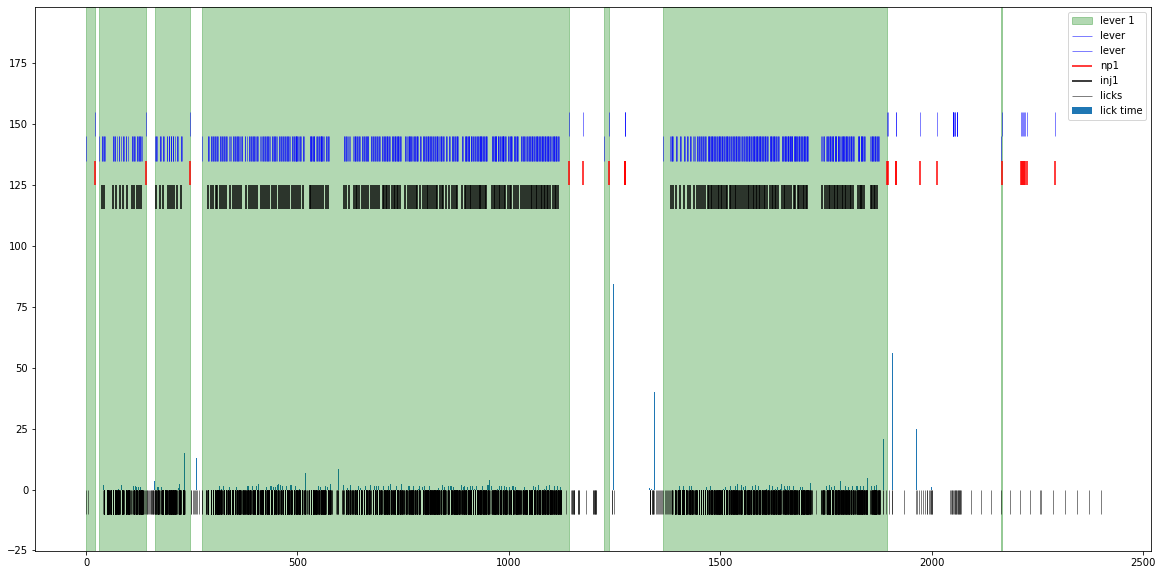

In [35]:
plt.figure(figsize=(20,10))
plt.bar(c1.lk1_start, [b-a for a,b in c1.LK1],label='lick time')

lever = c1._non(c1._union(*[[a] for a in [(i,i+10*(n+1)) for n,i in enumerate(c1.np1)] ]),c1.end)
for n,(a,b) in enumerate(lever):
    plt.axvspan(a,b,alpha=0.3,color='g',label='_'*n+'lever 1')
plt.eventplot(c1.l1_0/1000,lineoffsets=150,linelengths=10,linewidths=0.5,color='b',label='lever')
plt.eventplot(c1.l1_1/1000,lineoffsets=140,linelengths=10,linewidths=0.5,color='b',label='lever')
plt.eventplot(c1.np1,lineoffsets=130,linelengths=10,color='r',label='np1')
plt.eventplot(c1.inj1,lineoffsets=120,linelengths=10,color='k',label='inj1')
for n,(a,b) in enumerate(c1.LK1):
    plt.eventplot(np.linspace(a,b,c1.lk1_intnb[n]),lineoffsets=-5,linelengths=10,linewidths=0.5,color='k',label=n*'_'+'licks')
plt.legend()

In [36]:
c1.get('L1')[c1.get('L1')['']]

,TIME,F,ID,_P,_V,_L,_R,_T,_W,_X,_Y,_Z
2,0,2,1,1,0,0,0,0,0,0,0,0
14,20156,2,1,0,0,0,0,0,0,0,0,0
20,30171,2,1,1,0,0,0,0,0,0,0,0
21,37924,2,1,1,1,1,0,1,0,0,1,0
23,38533,2,1,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2836,2215994,2,1,0,0,0,0,292,0,6,286,0
2842,2217648,2,1,0,0,0,0,292,0,6,286,0
2848,2220019,2,1,0,0,0,0,292,0,6,286,0
2854,2226197,2,1,0,0,0,0,292,0,6,286,0


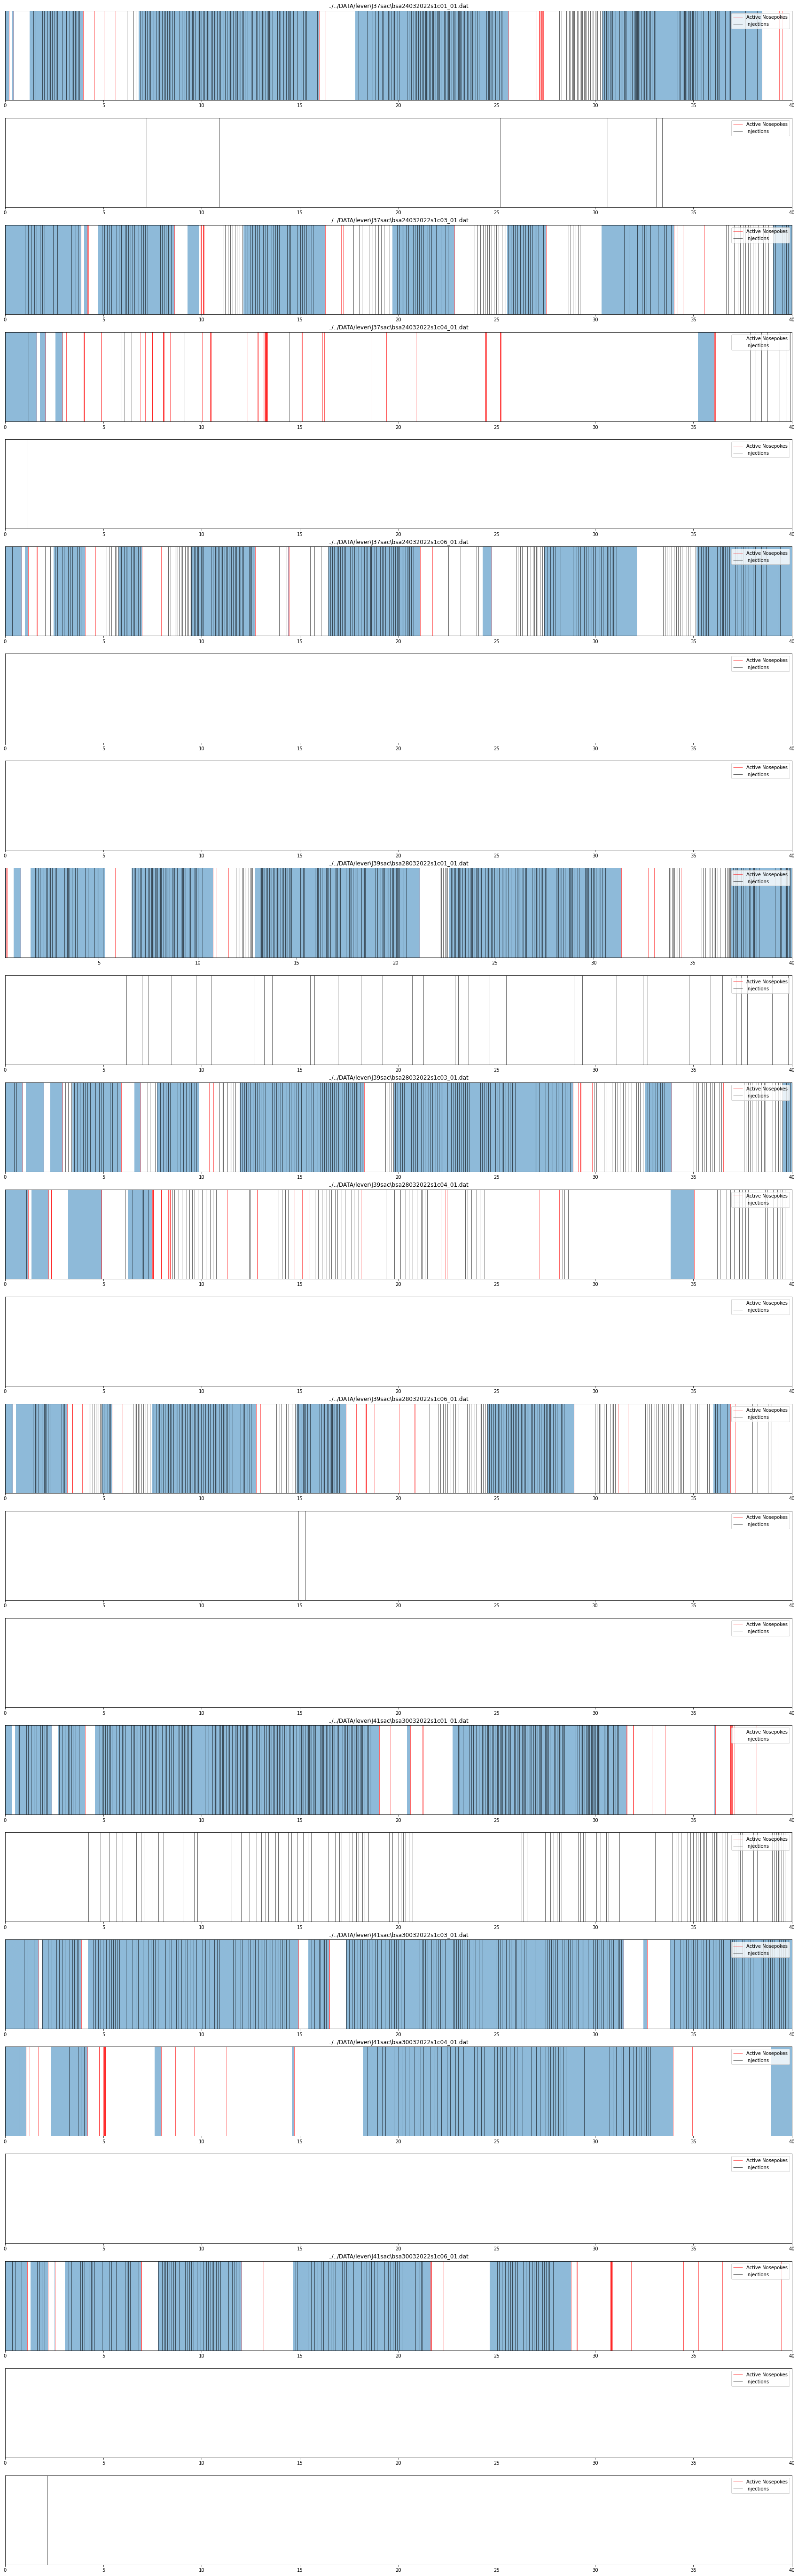

In [11]:
fig,ax = plt.subplots(len(levers.sessions),figsize=(30,100))
for n,(k,obj) in enumerate(levers.sessions.items()):
    retracted = [[a] for a in [(i,i+10*(n+1)) for n,i in enumerate(obj.np1)] ]
    obj._graph(ax[n],'np1')
    obj._graph(ax[n],'inj1')
    if retracted:
        obj._graph(ax[n],obj._non(obj._union(*retracted),obj.end),alpha=0.5)
        ax[n].title.set_text(k)